<b>Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from IPython.display import display
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For Data Augmentation
from tensorflow.keras.applications.resnet50 import ResNet50  # load the Pre-Trained Model ResNet50
from tensorflow.keras.applications.vgg16 import VGG16         # Load the Pre-Trained Model VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense , Flatten , Conv2D, MaxPool2D , Dropout
from tensorflow.keras.optimizers import Adam , SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<b>Load Dataset Images

In [3]:
def load_dataset(path):
    # Define the List for Images & Labels
    Images , Labels = [] , []
    label = 0
    # Iterate the Dataset with the Folders
    for folderName in os.listdir(path):
        # Create the New Path for the Images
        imagesPath = os.path.join(path , folderName)
        # Iterate the Each Folder Images
        for images in os.listdir(imagesPath):
            # Define the Path of the Image
            imagePath = os.path.join(imagesPath , images)
            # Read the Image with PIL
            pilImage = Image.open(imagePath)

            # # Resize the Image
            # resizedImage = pilImage.resize((150,150))

             # Convert the Numpy Array
            cv2Image = np.array(pilImage)

             # Change the Type of the Image
            cv2Image = cv2Image.astype("float32")

            # Normalize the Data of Image
            cv2Image = cv2Image / 255

            # Append the Images and Labels in the List
            Images.append(cv2Image)
            Labels.append(label)
        label += 1
    return Images , Labels

In [4]:
# Define the Path of the Dataset
datasetPath = "/content/drive/MyDrive/ID Card Dataset Info/ID Card Augmented Dataset"   # Change the Dataset Path

# Load the Dataset
Images , Labels = load_dataset(datasetPath)

# Display the Shapes of the Images and Labels
print(f"Shape of the Images is : {np.shape(Images)}")
print(f"Shape of the Labels is : {np.shape(Labels)}")

Shape of the Images is : (1500, 224, 224, 3)
Shape of the Labels is : (1500,)


<b>Convert Numpy Array

In [5]:
# Convert the Images and Labels into Numpy Array
Images = np.array(Images)
Labels = np.array(Labels)

# Display the Shape of the Images and Labels
print(f"Shape of the Images is : {Images.shape}")
print(f"Shape of the Labels is : {Labels.shape}")

Shape of the Images is : (1500, 224, 224, 3)
Shape of the Labels is : (1500,)


<b>Define Label of Dataset

In [6]:
# Define the Labels
def class_label(index):
    label = [
        "B_W Back QRCode Image",
        "B_W Back Marker Image",
        "B_W Front Marker Image",
        "B_W Front Gender,CNIC,Date Image",
        "B_W Back Image",
        "B_W Front Image",
        "B_W Front Name Change Image",
        "B_W Back Ripped Image",
        "B_W Front Face Change Image",
        "B_W Back Picture-In-Picture Image",
        "Color Front Face Change Image",
        "Color Back Picture-In-Picture Image",
        "Color Back Image",
        "B_W Front Signature Swap Image",
        "B_W Front Ripped Image",
        "B_W Front Picture-In-Picture Image",
        "Color Back Marker Image",
        "Color Back QRCode Change Image",
        "Color Back Ripped Image",
        "Color Front Gender,CNIC,Date Image",
        "Original Back Image",
        "Original Front Image",
        "Color Front Signature Swap Image",
        "Color Front Image",
        "Color Front Picture-In-picture Image",
        "Color Front Ripped Image",
        "Color Front Name Change Image",
        "Color Front Marker Image"]
    return label[index]

<b>Visualization Augmented Dataset Images

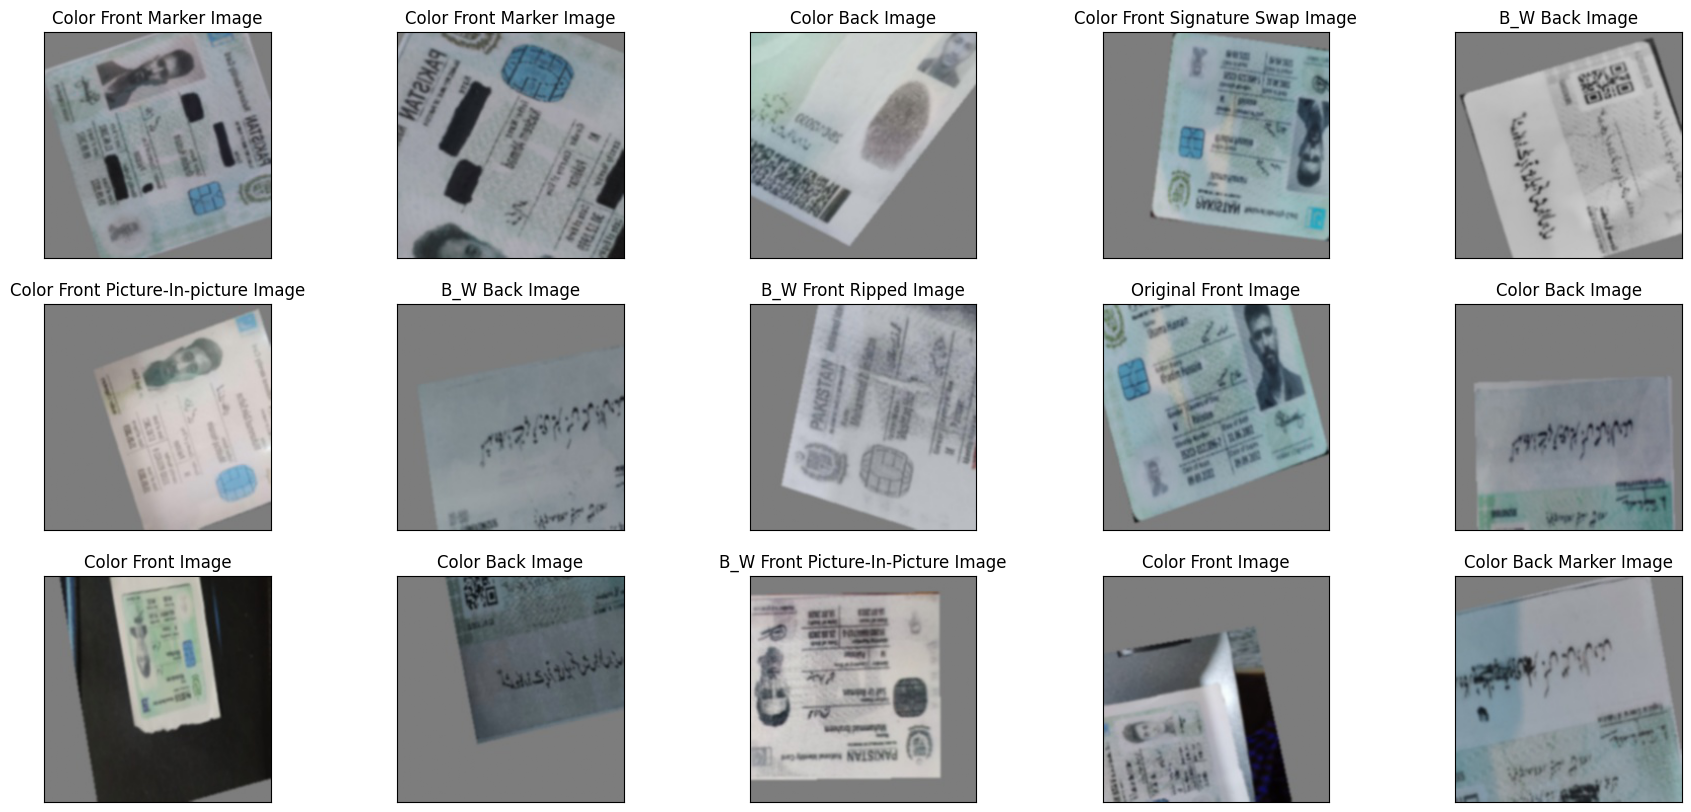

In [7]:
# Visualization Images and Labels

# Set the Figure
plt.figure(figsize = (22,10))
for index in range(0,15):
    # Get the Radom Number
    choice = random.randint(0, len(Images)-1)
    ax = plt.subplot(3,5,index+1)
    plt.imshow(Images[choice])
    plt.xticks([])
    plt.yticks([])
    plt.title(class_label(Labels[choice]))
plt.show()

<b>Convert Labels OneHotEncoder Format

In [8]:
# Create the Object of the OneHotEncoder
Encoder = OneHotEncoder()

# Apply the OneHotEncoder in the Dataset
labelHot = Encoder.fit_transform(Labels.reshape(-1, 1)).toarray()

In [ ]:
# Check the Balanced & Imbalanced Dataset
classes , counts = np.unique(Labels, return_counts=True)

# Display the Count and Classes

for index in range(len(classes)):
  print(f"Here is the {index+1} Class : {class_label(classes[index])} \nHere is the Count : {counts[index]} \n")

<b>Split the Dataset into Training & Validation

In [9]:
# Split the Dataset into Training and Testing
trainData , testData , trainLabel , testLabel = train_test_split(Images, labelHot , test_size = 0.3 , random_state = 42)

# Display the Shape of the Training and Testing Dataset
print(f"Shape of the Train Data  is : {trainData.shape}")
print(f"Shape of the Train Label is : {trainLabel.shape}")
print(f"Shape of the Test  Data  is : {testData.shape}")
print(f"Shape of the Test  Label is : {testLabel.shape}")

Shape of the Train Data  is : (1050, 224, 224, 3)
Shape of the Train Label is : (1050, 28)
Shape of the Test  Data  is : (450, 224, 224, 3)
Shape of the Test  Label is : (450, 28)


In [10]:
# Split the Dataset into Training and Validation
x_train , x_val , y_train , y_val = train_test_split(trainData, trainLabel , test_size = 0.2 , random_state = 42)

# Display the Shapes
print(f"Shape of the X Train is : {x_train.shape}")
print(f"Shape of the Y Train is : {y_train.shape}")
print(f"Shape of the X Val.  is : {x_val.shape}")
print(f"Shape of the Y Val.  is : {y_val.shape}")

Shape of the X Train is : (840, 224, 224, 3)
Shape of the Y Train is : (840, 28)
Shape of the X Val.  is : (210, 224, 224, 3)
Shape of the Y Val.  is : (210, 28)


<b>Transfer learning Model (VGG16 Model) for ID Card Classification

In [11]:
# Define the Model VGG16
def create_model(learning_rate , optimizer , dropout_rate):
  # Load the Resnet50 Pre-Trained Model
  preModel = VGG16(weights='imagenet' , input_shape=(224, 224, 3) , include_top=False , classes = 28)

  # Freeze the Parameters
  for layer in preModel.layers[:-4]:
      layer.trainable = False

  # Create the VGG16 Model
  vgg16Model = Sequential([
      preModel,
      Flatten(),
      Dense(4096,activation="relu"),
      Dropout(dropout_rate),
      Dense(256, activation='relu'),
      Dropout(dropout_rate),
      Dense(28, activation='softmax')
  ])

  # Compile the Model
  vgg16Model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer(learning_rate=learning_rate),
      metrics=['accuracy']
  )

  # Return the Model
  return vgg16Model

In [12]:
# Define the Parameters for the GridSearch CV
modelParams = {
    'learning_rate': [0.001, 0.01],
    'optimizer': [Adam, SGD],
    'dropout_rate': [0.3,0.5]
}

# Create the Model with the Keras Classifier
VGG16Model = KerasClassifier(build_fn=create_model)

# Create the Object of GridSearchCV
grid_search = GridSearchCV(estimator=VGG16Model, param_grid=modelParams, cv=3)
grid_result = grid_search.fit(x_train, y_train, validation_data=(x_val, y_val))

<ipython-input-12-3da121480fa0>:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  VGG16Model = KerasClassifier(build_fn=create_model)


27/27 [==============================] - 9s 296ms/step - loss: 3.4313 - accuracy: 0.0881 - val_loss: 3.1347 - val_accuracy: 0.0952


In [13]:
# Display the Results with GridSearchcv
print("Best Hyperparameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

Best Hyperparameters:  {'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.sgd.SGD'>}
Best Accuracy:  0.12500000248352686


In [14]:
# create the model with good Results
learning_rate = grid_result.best_params_["learning_rate"]
optimizer     = grid_result.best_params_["optimizer"]
dropout       = grid_result.best_params_["dropout_rate"]

# Call the Create Model Function and Create the Model with Best Parameter
vgg16Finalmodel = create_model(learning_rate , optimizer , dropout)

# Fit the Model
# Fit the Resnet50 Model for Custom Dataset
history = vgg16Finalmodel.fit(x_train , y_train , validation_data = (x_val , y_val) , epochs = 100 , batch_size = 32 , verbose = 1)

Epoch 1/100
27/27 [==============================] - 7s 230ms/step - loss: 3.4308 - accuracy: 0.0690 - val_loss: 3.1259 - val_accuracy: 0.0810
Epoch 2/100
27/27 [==============================] - 5s 204ms/step - loss: 3.2009 - accuracy: 0.1119 - val_loss: 3.1240 - val_accuracy: 0.0952
Epoch 3/100
27/27 [==============================] - 6s 207ms/step - loss: 3.1668 - accuracy: 0.1095 - val_loss: 3.1133 - val_accuracy: 0.1476
Epoch 4/100
27/27 [==============================] - 6s 215ms/step - loss: 3.0840 - accuracy: 0.1238 - val_loss: 3.0779 - val_accuracy: 0.1048
Epoch 5/100
27/27 [==============================] - 6s 209ms/step - loss: 3.1094 - accuracy: 0.1119 - val_loss: 3.0707 - val_accuracy: 0.1238
Epoch 6/100
27/27 [==============================] - 6s 212ms/step - loss: 3.0762 - accuracy: 0.1250 - val_loss: 3.0820 - val_accuracy: 0.1429
Epoch 7/100
27/27 [==============================] - 5s 193ms/step - loss: 3.0276 - accuracy: 0.1381 - val_loss: 3.0709 - val_accuracy: 0.1048

In [15]:
# Display the Accuracy and loss of the Model with validation Dataset
loss , accuracy = vgg16Finalmodel.evaluate(x_val , y_val)
print(f"Here is the Loss : {loss}")
print(f"Here is the Accuracy : {accuracy}")

7/7 [==============================] - 1s 125ms/step - loss: 2.7237 - accuracy: 0.3095
Here is the Loss : 2.72365140914917
Here is the Accuracy : 0.3095238208770752


**Testing Model with Testing Dataset**

In [16]:
# Predict the Results with Testing Dataset
prediction = []
testingRes = []
for index in range(len(testData)):
  prediction.append(np.argmax(vgg16Finalmodel.predict(np.expand_dims(testData[index],axis=0))))
  testingRes.append(np.argmax(testLabel[index]))

1/1 [==============================] - 0s 64ms/step


In [18]:
# Display the Acuraccy of the Model
print(f"Here is the Accuracy of the Model in the Testing Dataset : {accuracy_score(testingRes , prediction)}")

Here is the Accuracy of the Model in the Testing Dataset : 0.36


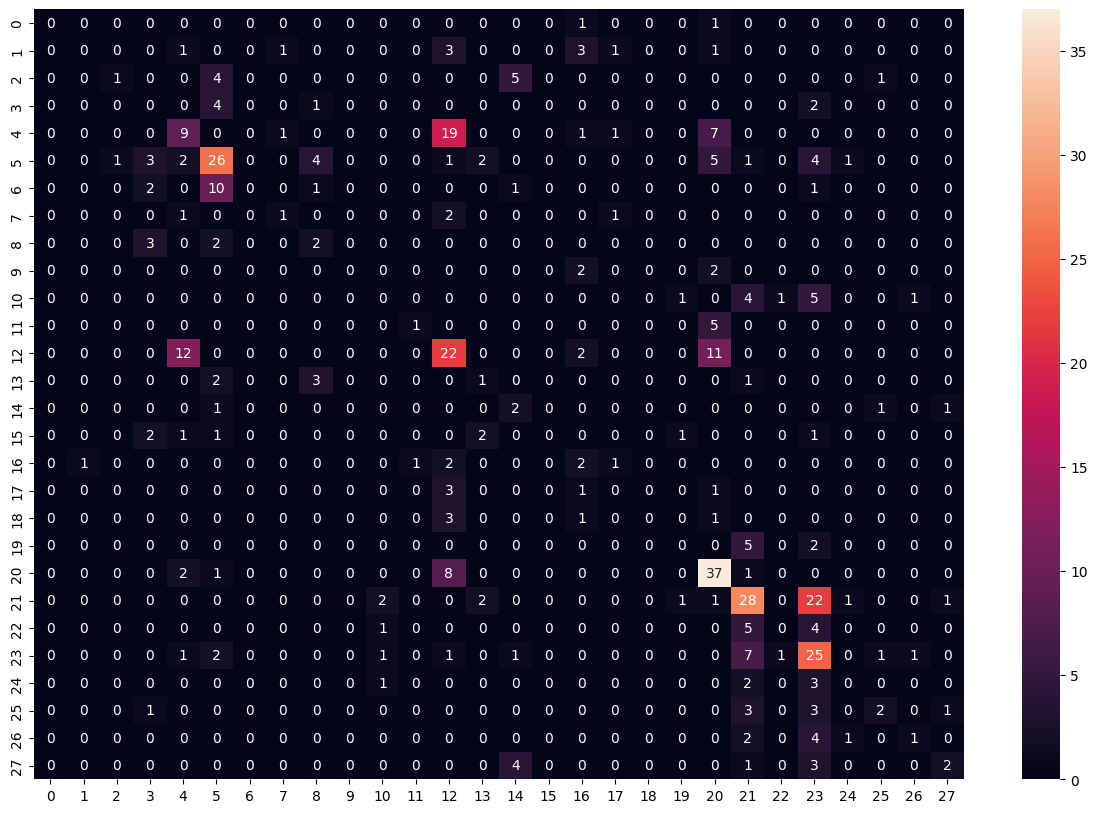

In [19]:
# Calculate the Confusion Matrix
confMatrix = confusion_matrix(testingRes , prediction)

# Display the Confusion Matrix
plt.figure(figsize = (15,10))
sns.heatmap(confMatrix , annot = True)
plt.show()

In [20]:
# Display the Classification Report
print(classification_report(testingRes , prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        10
           2       0.50      0.09      0.15        11
           3       0.00      0.00      0.00         7
           4       0.31      0.24      0.27        38
           5       0.49      0.52      0.50        50
           6       0.00      0.00      0.00        15
           7       0.33      0.20      0.25         5
           8       0.18      0.29      0.22         7
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00        12
          11       0.50      0.17      0.25         6
          12       0.34      0.47      0.40        47
          13       0.14      0.14      0.14         7
          14       0.15      0.40      0.22         5
          15       0.00      0.00      0.00         8
          16       0.15      0.29      0.20         7
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


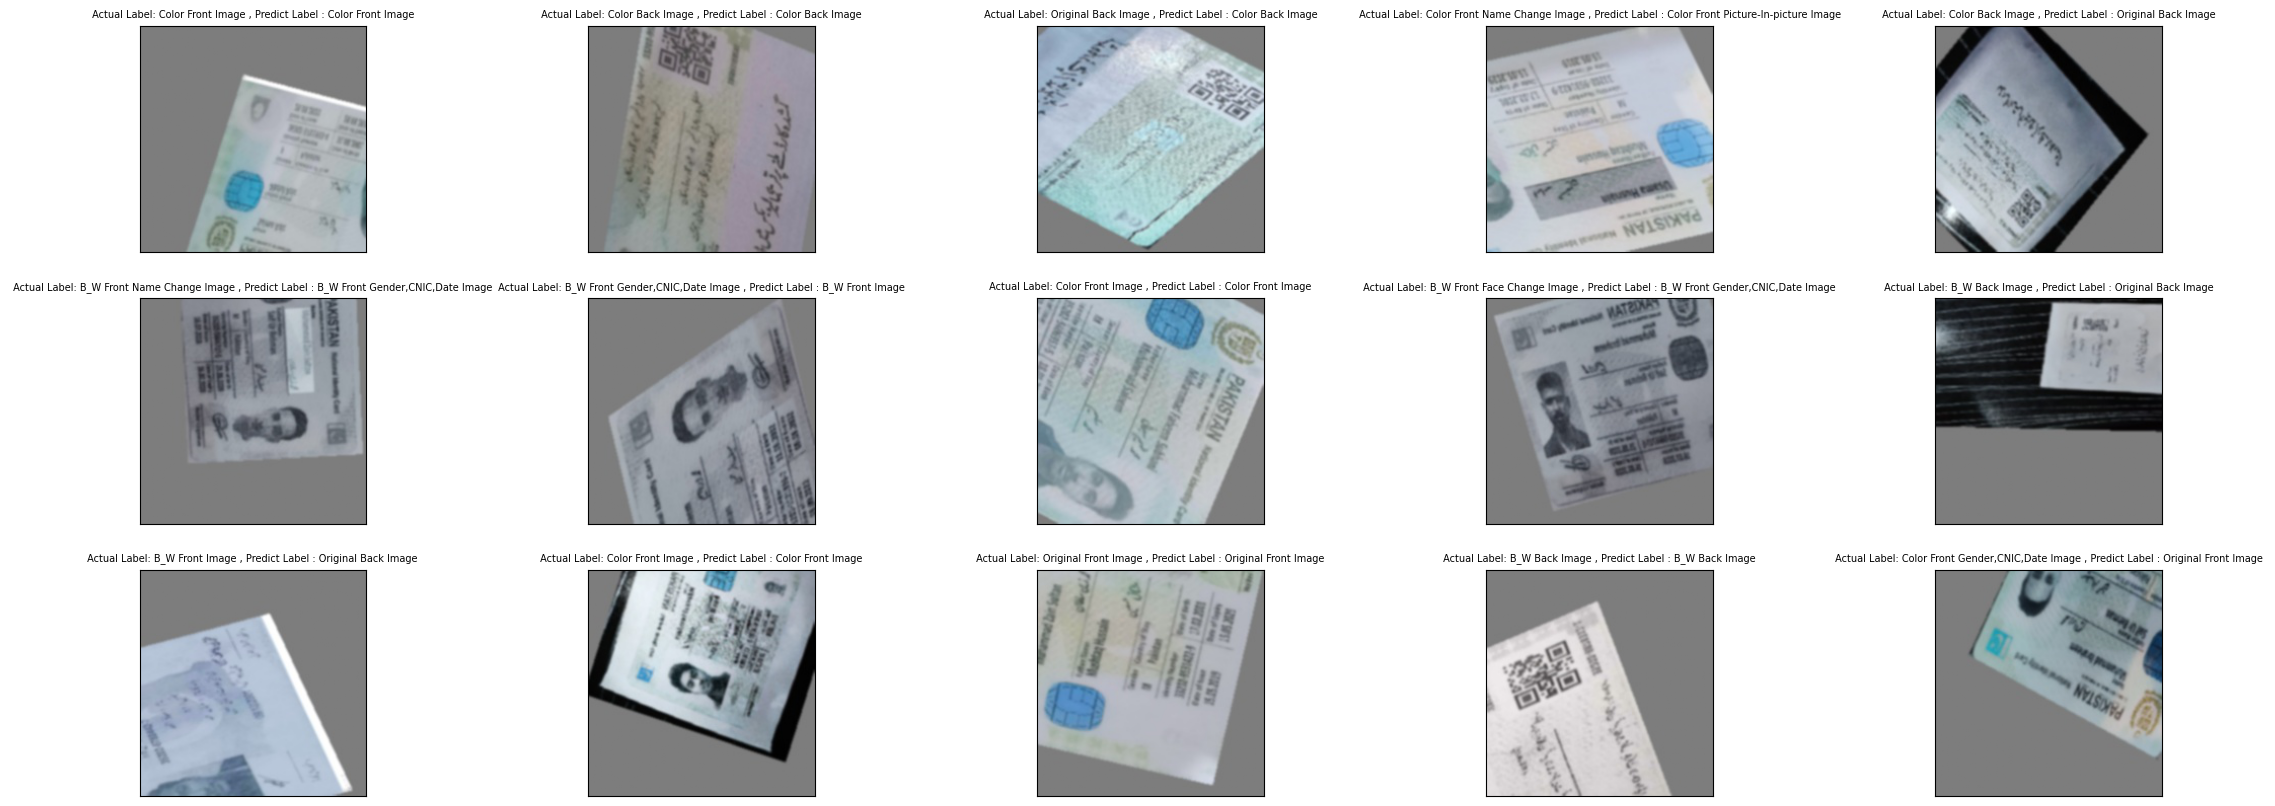

In [21]:
# Visualization Images with Actual and Testing Labels

# Set the Figure
plt.figure(figsize = (28,10))
for index in range(0,15):
    # Get the Radom Number
    choice = random.randint(0, len(testData)-1)
    ax = plt.subplot(3,5,index+1)
    plt.imshow(testData[choice])
    plt.xticks([])
    plt.yticks([])

    plt.title(" Actual Label: {} , Predict Label : {} ".format(class_label(np.argmax(testLabel[choice])) , class_label(prediction[choice])) , fontsize = 7)
plt.show()

**Test the Model Unseen Dataset**

In [22]:
def load_dataset(path):
    # Define the List for Images & Labels
    Images , Labels = [] , []
    label = 0
    # Iterate the Dataset with the Folders
    for folderName in os.listdir(path):
        # Create the New Path for the Images
        imagesPath = os.path.join(path , folderName)
        # Iterate the Each Folder Images
        for images in os.listdir(imagesPath):
            # Define the Path of the Image
            imagePath = os.path.join(imagesPath , images)
            # Read the Image with PIL
            pilImage = Image.open(imagePath)

            # # Resize the Image
            resizedImage = pilImage.resize((224,224))

             # Convert the Numpy Array
            cv2Image = np.array(resizedImage)

             # Change the Type of the Image
            cv2Image = cv2Image.astype("float32")

            # Normalize the Data of Image
            cv2Image = cv2Image / 255

            # Append the Images and Labels in the List
            Images.append(cv2Image)
            Labels.append(label)
        label += 1
    return Images , Labels

In [23]:
# Load the testing Unseen Dataset

# Define the Path of the Dataset
datasetPath = "/content/drive/MyDrive/ID Card Dataset Info/Unseen Testing Dataset"   # Change the Dataset Path

# Load the Dataset
unImages , unLabels = load_dataset(datasetPath)

# Display the Shapes of the Images and Labels
print(f"Shape of the Images is : {np.shape(unImages)}")
print(f"Shape of the Labels is : {np.shape(unLabels)}")

Shape of the Images is : (24, 224, 224, 3)
Shape of the Labels is : (24,)


In [24]:
# Convert the Numpy Array
unImages = np.array(unImages)
unLabels = np.array(unLabels)

In [25]:
# Define the Class Label of Testing Unseen Dataset
def test_class_label(index):
  labels = {
      "0" : 21,
      "1" : 4,
      "2" : 23,
      "3" : 20,
      "4" : 12,
      "5" : 5
  }
  return labels[index]

In [26]:
# Correct the Labels of the Unseen Test Dataset
for index in range(len(unLabels)):
  # Get the Value
  value = test_class_label(str(unLabels[index]))
  # Update the Value
  unLabels[index] = value

In [27]:
# Testing the Dataset with VGG16 mModel
predictionTesting = []
for index in range(len(unImages)):
  predictionTesting.append(np.argmax(vgg16Finalmodel.predict(np.expand_dims(unImages[index],axis=0))))

1/1 [==============================] - 0s 27ms/step


In [28]:
# Display The Accuracy of the Model with Unseen Test Dataset
print(f"Here is the Accuracy of the Model in the Unseen Dataset : {accuracy_score(list(unLabels),predictionTesting)}")

Here is the Accuracy of the Model in the Unseen Dataset : 0.375


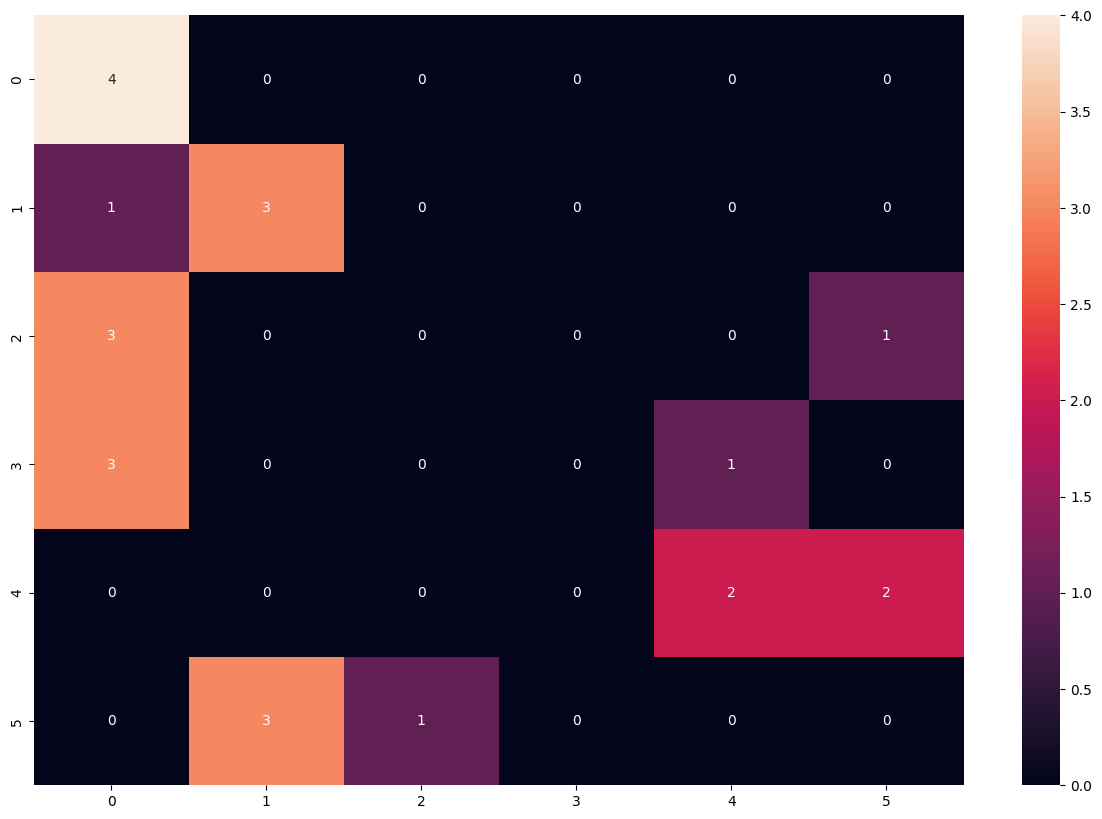

In [29]:
# Calculate the Confusion Matrix
confMatrix = confusion_matrix(list(unLabels) , predictionTesting)

# Display the Confusion Matrix
plt.figure(figsize = (15,10))
sns.heatmap(confMatrix , annot = True)
plt.show()